### Библиотеки

In [24]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback

### Подготовка данных

In [27]:
data_dir = 'C:/Users/imedz/OneDrive/Desktop/AI/Labs2/images'
file_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.jpg')]
labels = [fname.split('_')[0] for fname in os.listdir(data_dir) if fname.endswith('.jpg')]

label_to_id = {label: idx for idx, label in enumerate(set(labels))}
ids = [label_to_id[label] for label in labels]

X_train, X_test, y_train, y_test = train_test_split(file_paths, ids, test_size=0.2, random_state=42)

id_to_label = {idx: label for label, idx in label_to_id.items()}
train_labels = [id_to_label[id] for id in y_train]
test_labels = [id_to_label[id] for id in y_test]

train_df = pd.DataFrame({'filename': X_train, 'class': train_labels})
test_df = pd.DataFrame({'filename': X_test, 'class': test_labels})

###  Генерация данных для обучения и тестирования

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, x_col='filename', y_col='class',
    target_size=(224, 224), batch_size=32, class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df, x_col='filename', y_col='class',
    target_size=(224, 224), batch_size=32, class_mode='categorical'
)

Found 5912 validated image filenames belonging to 35 classes.
Found 1478 validated image filenames belonging to 35 classes.


In [29]:
from collections import Counter

unique_labels = set(labels)
print("Уникальные породы:", unique_labels)
print("Количество уникальных пород:", len(unique_labels))

label_counts = Counter(labels)
print("Количество образцов по породам:", label_counts)

train_label_counts = Counter(train_labels)
print("Количество образцов по породам в тренировочных данных:", train_label_counts)

test_label_counts = Counter(test_labels)
print("Количество образцов по породам в тестовых данных:", test_label_counts)

Уникальные породы: {'chihuahua', 'shiba', 'yorkshire', 'american', 'great', 'miniature', 'newfoundland', 'Birman', 'Sphynx', 'pug', 'german', 'saint', 'Bengal', 'Abyssinian', 'Ragdoll', 'keeshond', 'Bombay', 'samoyed', 'pomeranian', 'scottish', 'wheaten', 'Egyptian', 'Maine', 'english', 'Persian', 'staffordshire', 'leonberger', 'Siamese', 'Russian', 'basset', 'boxer', 'British', 'havanese', 'japanese', 'beagle'}
Количество уникальных пород: 35
Количество образцов по породам: Counter({'american': 400, 'english': 400, 'Abyssinian': 200, 'basset': 200, 'beagle': 200, 'Bengal': 200, 'Birman': 200, 'Bombay': 200, 'boxer': 200, 'British': 200, 'chihuahua': 200, 'Egyptian': 200, 'german': 200, 'great': 200, 'havanese': 200, 'japanese': 200, 'keeshond': 200, 'leonberger': 200, 'Maine': 200, 'miniature': 200, 'newfoundland': 200, 'Persian': 200, 'pomeranian': 200, 'pug': 200, 'Ragdoll': 200, 'Russian': 200, 'saint': 200, 'samoyed': 200, 'shiba': 200, 'Siamese': 200, 'Sphynx': 200, 'wheaten': 20

### Определение моделей

In [30]:
def build_model(base_model, num_classes=35):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_vgg16 = build_model(base_model_vgg16)

base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_vgg19 = build_model(base_model_vgg19)

base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet50 = build_model(base_model_resnet50)

### Обучение

In [31]:
print_loss_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch + 1}: Loss = {logs['loss']}, Val Loss = {logs['val_loss']}"))

history_vgg16 = model_vgg16.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=[print_loss_callback])

Epoch 1/10


c:\python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0467 - loss: 3.6085Epoch 1: Loss = 3.5450289249420166, Val Loss = 3.3938345909118652
185/185 ━━━━━━━━━━━━━━━━━━━━ 829s 4s/step - accuracy: 0.0468 - loss: 3.6081 - val_accuracy: 0.0724 - val_loss: 3.3938
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0917 - loss: 3.3919Epoch 2: Loss = 3.35050892829895, Val Loss = 3.2264726161956787
185/185 ━━━━━━━━━━━━━━━━━━━━ 840s 5s/step - accuracy: 0.0918 - loss: 3.3917 - val_accuracy: 0.1461 - val_loss: 3.2265
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1588 - loss: 3.1853Epoch 3: Loss = 3.144735097885132, Val Loss = 3.049081802368164
185/185 ━━━━━━━━━━━━━━━━━━━━ 852s 5s/step - accuracy: 0.1588 - loss: 3.1850 - val_accuracy: 0.2145 - val_loss: 3.0491
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2100 - loss: 3.0116Epoch 4: Loss = 2.9779303073883057, Val Loss = 2.898970127105713
185/185 ━━━━━━━━━━━━━━━━━━━━ 824s 4s/step - accuracy: 0.2100 -

In [32]:
history_vgg19 = model_vgg19.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=[print_loss_callback])

Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0421 - loss: 3.6172Epoch 1: Loss = 3.5606069564819336, Val Loss = 3.4050726890563965
185/185 ━━━━━━━━━━━━━━━━━━━━ 1233s 7s/step - accuracy: 0.0421 - loss: 3.6169 - val_accuracy: 0.1035 - val_loss: 3.4051
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0916 - loss: 3.4023Epoch 2: Loss = 3.3695545196533203, Val Loss = 3.2684972286224365
185/185 ━━━━━━━━━━━━━━━━━━━━ 1259s 7s/step - accuracy: 0.0917 - loss: 3.4022 - val_accuracy: 0.1238 - val_loss: 3.2685
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1419 - loss: 3.2336Epoch 3: Loss = 3.2016873359680176, Val Loss = 3.119002103805542
185/185 ━━━━━━━━━━━━━━━━━━━━ 1240s 7s/step - accuracy: 0.1419 - loss: 3.2334 - val_accuracy: 0.1773 - val_loss: 3.1190
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1690 - loss: 3.0797Epoch 4: Loss = 3.0567328929901123, Val Loss = 2.99025297164917
185/185 ━━━━━━━━━━━━━━━━━━━━ 1266s 7s/step - a

In [33]:
history_resnet50 = model_resnet50.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=[print_loss_callback])

Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0347 - loss: 3.7979Epoch 1: Loss = 3.6968400478363037, Val Loss = 3.5353941917419434
185/185 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.0347 - loss: 3.7974 - val_accuracy: 0.0629 - val_loss: 3.5354
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0506 - loss: 3.5617Epoch 2: Loss = 3.546046018600464, Val Loss = 3.508443593978882
185/185 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.0506 - loss: 3.5616 - val_accuracy: 0.0507 - val_loss: 3.5084
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0562 - loss: 3.5137Epoch 3: Loss = 3.510340690612793, Val Loss = 3.495321750640869
185/185 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.0562 - loss: 3.5137 - val_accuracy: 0.0535 - val_loss: 3.4953
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0578 - loss: 3.4747Epoch 4: Loss = 3.47691011428833, Val Loss = 3.454259157180786
185/185 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy:

### Оценка моделей

In [34]:
accuracy_vgg16 = model_vgg16.evaluate(test_generator)
accuracy_vgg19 = model_vgg19.evaluate(test_generator)
accuracy_resnet50 = model_resnet50.evaluate(test_generator)

print("Точность VGG16:", accuracy_vgg16[1])
print("Точность VGG19:", accuracy_vgg19[1])
print("Точность ResNet50:", accuracy_resnet50[1])

47/47 ━━━━━━━━━━━━━━━━━━━━ 184s 4s/step - accuracy: 0.4422 - loss: 2.2279
47/47 ━━━━━━━━━━━━━━━━━━━━ 233s 5s/step - accuracy: 0.3384 - loss: 2.4343
47/47 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.0835 - loss: 3.4154
Точность VGG16: 0.4174560308456421
Точность VGG19: 0.35520973801612854
Точность ResNet50: 0.09675236791372299


Самой точной оказалась VGG16. Она и будет использоваться дальше

### Двоичная классификация "кошки против собак"

In [35]:
breed_to_type = {
    'Abyssinian': 'cat', 'Bengal': 'cat', 'Birman': 'cat', 'Bombay': 'cat',
    'British': 'cat', 'Egyptian': 'cat', 'Maine': 'cat', 'Persian': 'cat',
    'Ragdoll': 'cat', 'Russian': 'cat', 'Siamese': 'cat', 'Sphynx': 'cat',
    'american': 'dog', 'basset': 'dog', 'beagle': 'dog', 'boxer': 'dog',
    'chihuahua': 'dog', 'english': 'dog', 'german': 'dog', 'great': 'dog',
    'havanese': 'dog', 'japanese': 'dog', 'keeshond': 'dog', 'leonberger': 'dog',
    'miniature': 'dog', 'newfoundland': 'dog', 'pomeranian': 'dog', 'pug': 'dog',
    'saint': 'dog', 'samoyed': 'dog', 'scottish': 'dog', 'shiba': 'dog',
    'staffordshire': 'dog', 'wheaten': 'dog', 'yorkshire': 'dog'
}

binary_labels = [breed_to_type[label.split('_')[0]] for label in labels]

#Стратифицированное разбиение, чтобы гарантировать, что оба класса представлены в обоих наборах данных
X_train, X_test, y_train_binary, y_test_binary = train_test_split(
    file_paths, binary_labels,
    test_size=0.2, random_state=42, stratify=binary_labels
)

#Создание DataFrame для тренировочных и тестовых наборов
train_df_binary = pd.DataFrame({'filename': X_train, 'class': y_train_binary})
test_df_binary = pd.DataFrame({'filename': X_test, 'class': y_test_binary})

#Настройка генераторов изображений
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_binary = train_datagen.flow_from_dataframe(
    dataframe=train_df_binary, x_col='filename', y_col='class',
    target_size=(224, 224), batch_size=32, class_mode='binary'
)

test_generator_binary = test_datagen.flow_from_dataframe(
    dataframe=test_df_binary, x_col='filename', y_col='class',
    target_size=(224, 224), batch_size=32, class_mode='binary'
)


Found 5912 validated image filenames belonging to 2 classes.
Found 1478 validated image filenames belonging to 2 classes.


In [36]:
print("Количество 'cat' в тренировочных данных:", y_train_binary.count('cat'))
print("Количество 'dog' в тренировочных данных:", y_train_binary.count('dog'))
print("Количество 'cat' в тестовых данных:", y_test_binary.count('cat'))
print("Количество 'dog' в тестовых данных:", y_test_binary.count('dog'))

Количество 'cat' в тренировочных данных: 1920
Количество 'dog' в тренировочных данных: 3992
Количество 'cat' в тестовых данных: 480
Количество 'dog' в тестовых данных: 998


In [37]:
#Строим бинарную модель
def build_binary_model(base_model):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

binary_model_vgg16 = build_binary_model(base_model_vgg16)

In [38]:
history_binary_vgg16 = binary_model_vgg16.fit(train_generator_binary, epochs=10, validation_data=test_generator_binary, callbacks=[print_loss_callback])

Epoch 1/10


c:\python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6951 - loss: 0.5855Epoch 1: Loss = 0.5318620800971985, Val Loss = 0.4284762144088745
185/185 ━━━━━━━━━━━━━━━━━━━━ 934s 5s/step - accuracy: 0.6953 - loss: 0.5852 - val_accuracy: 0.8234 - val_loss: 0.4285
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8085 - loss: 0.4303Epoch 2: Loss = 0.4031924307346344, Val Loss = 0.3430638313293457
185/185 ━━━━━━━━━━━━━━━━━━━━ 897s 5s/step - accuracy: 0.8086 - loss: 0.4301 - val_accuracy: 0.8667 - val_loss: 0.3431
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8594 - loss: 0.3486Epoch 3: Loss = 0.3328729271888733, Val Loss = 0.30408862233161926
185/185 ━━━━━━━━━━━━━━━━━━━━ 951s 5s/step - accuracy: 0.8594 - loss: 0.3485 - val_accuracy: 0.8816 - val_loss: 0.3041
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8788 - loss: 0.3011Epoch 4: Loss = 0.293603777885437, Val Loss = 0.26686131954193115
185/185 ━━━━━━━━━━━━━━━━━━━━ 987s 5s/step - accuracy: 0.

In [39]:
test_labels_binary = [breed_to_type[label] for label in test_df['class']]
binary_test_df = test_df.copy()
binary_test_df['class'] = test_labels_binary

binary_test_generator = test_datagen.flow_from_dataframe(
    dataframe=binary_test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

binary_accuracy = binary_model_vgg16.evaluate(binary_test_generator)
print("Точность бинарной классификации (кошки против собак):", binary_accuracy[1])

Found 1478 validated image filenames belonging to 2 classes.


c:\python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.9201 - loss: 0.2065
Точность бинарной классификации (кошки против собак): 0.924221932888031


### Построение Confusion Matrix

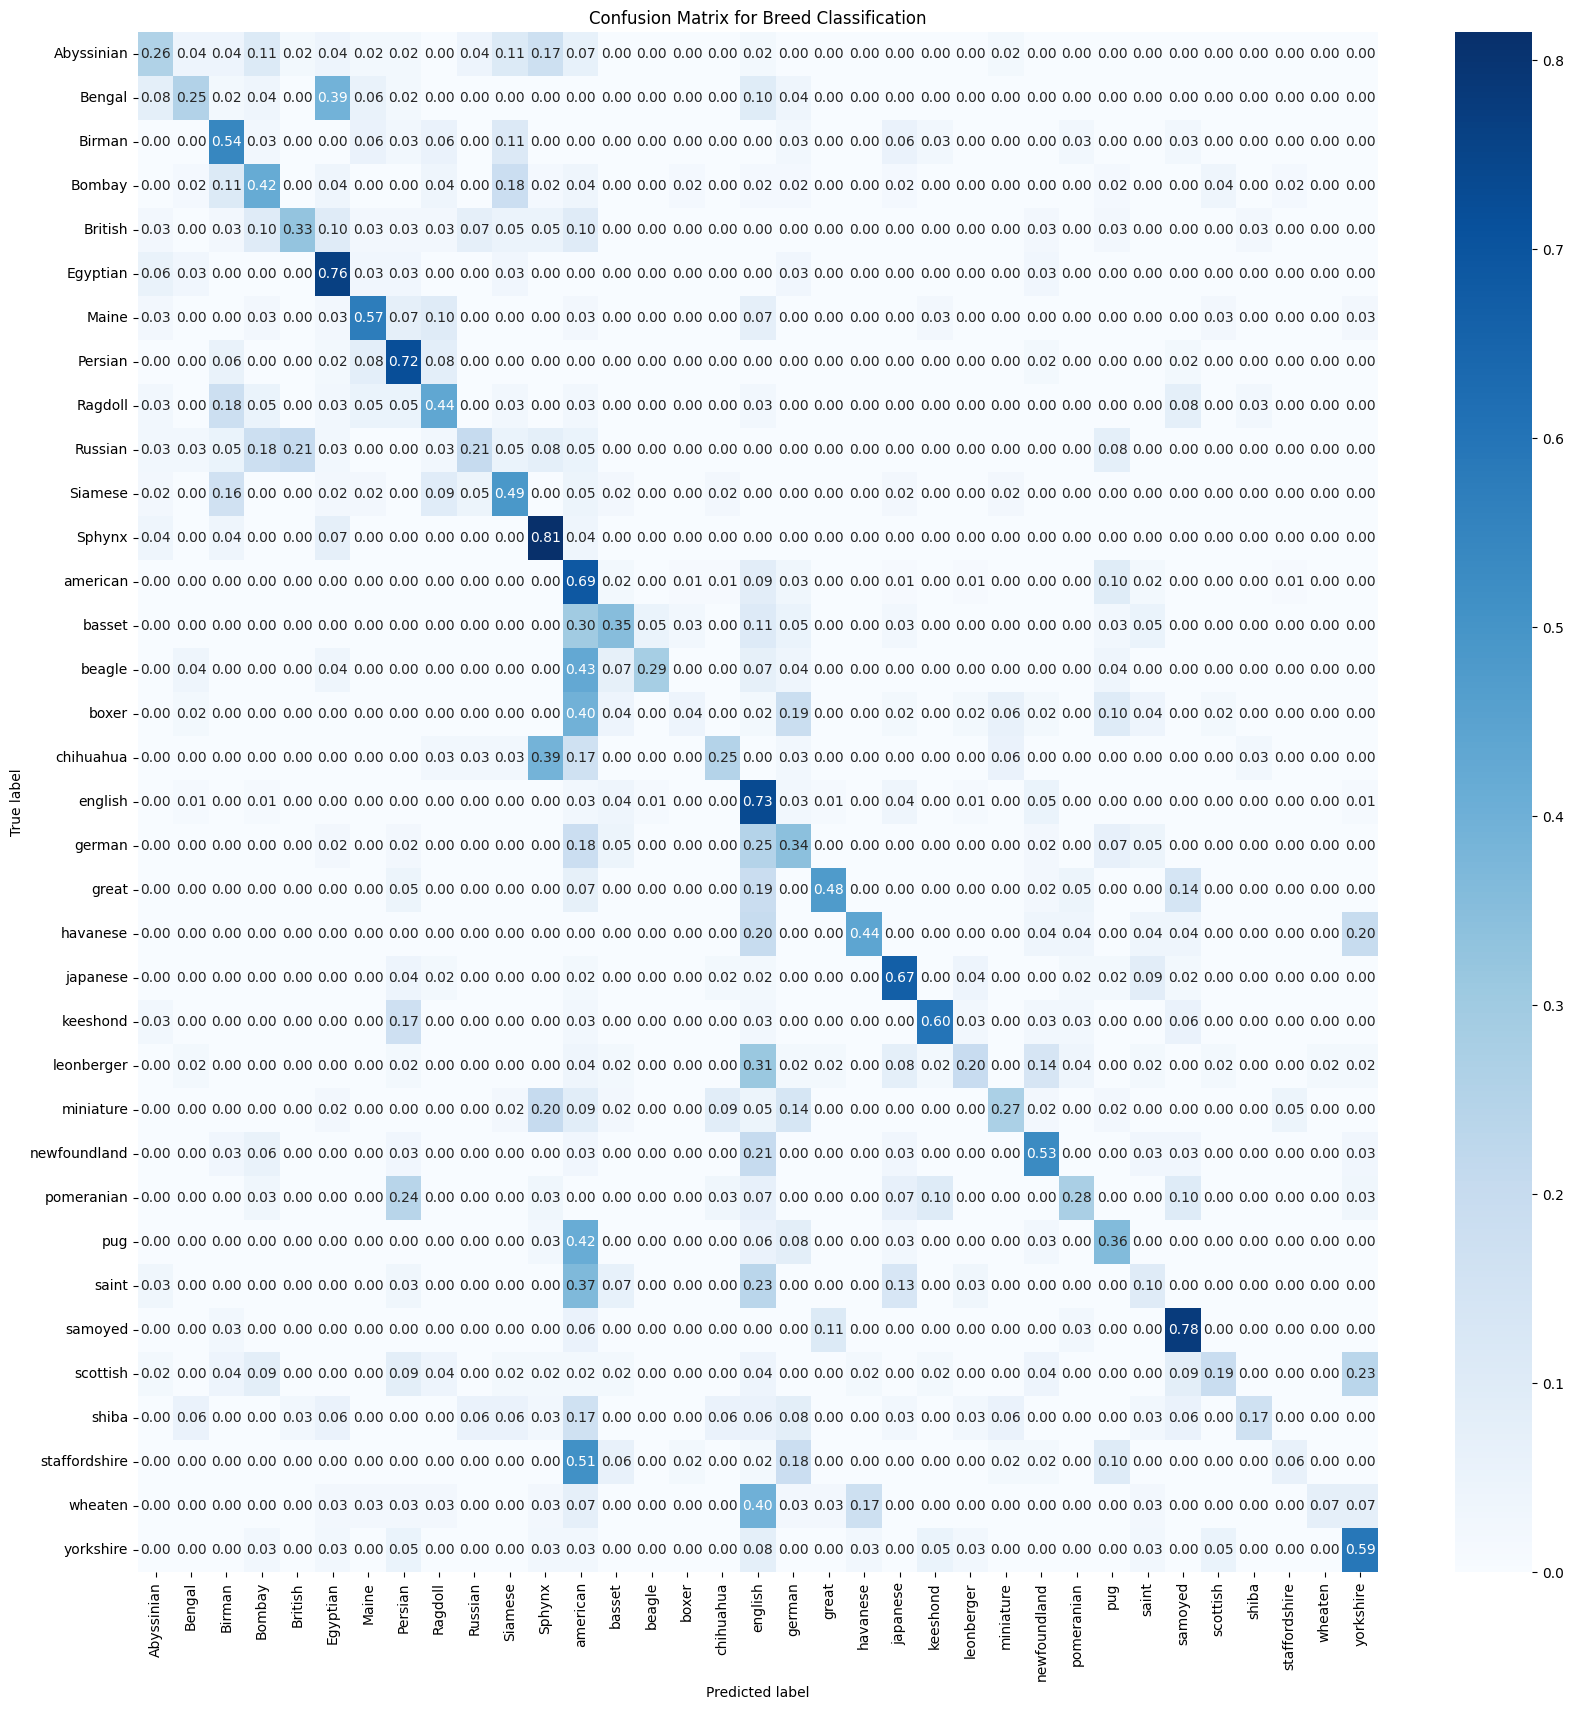

In [41]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def get_predictions(model, generator):
    predictions = []
    labels = []
    generator.reset()
    for _ in range(len(generator)):
        imgs, lbls = next(generator)
        preds = model.predict(imgs, verbose=0)
        preds = np.argmax(preds, axis=1)
        predictions.extend(preds)
        labels.extend(np.argmax(lbls, axis=1))
    return np.array(predictions), np.array(labels)

predictions, true_labels = get_predictions(model_vgg16, test_generator)

class_indices = test_generator.class_indices
breed_names = list(class_indices.keys())

breed_labels = [breed_names[idx] for idx in range(len(class_indices))]

cm = confusion_matrix(true_labels, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=breed_labels, yticklabels=breed_labels)
plt.title('Confusion Matrix for Breed Classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### Расчет top-3 и top-5 accuracy

In [1]:
from sklearn.metrics import top_k_accuracy_score

def get_prob_predictions(model, generator):
    predictions = []
    true_labels = []
    generator.reset()
    for _ in range(len(generator)):
        imgs, lbls = next(generator)
        preds = model.predict(imgs, verbose=0)
        predictions.append(preds)
        true_labels.extend(np.argmax(lbls, axis=1))
    predictions = np.concatenate(predictions, axis=0)
    return predictions, np.array(true_labels)

prob_predictions, true_labels = get_prob_predictions(model_vgg16, test_generator)

top3_accuracy = top_k_accuracy_score(true_labels, prob_predictions, k=3)
top5_accuracy = top_k_accuracy_score(true_labels, prob_predictions, k=5)

print("Top-3 Accuracy:", top3_accuracy)
print("Top-5 Accuracy:", top5_accuracy)

Top-3 Accuracy: 0.8010825439783491
Top-5 Accuracy: 0.6928281461434371


### GradCam

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


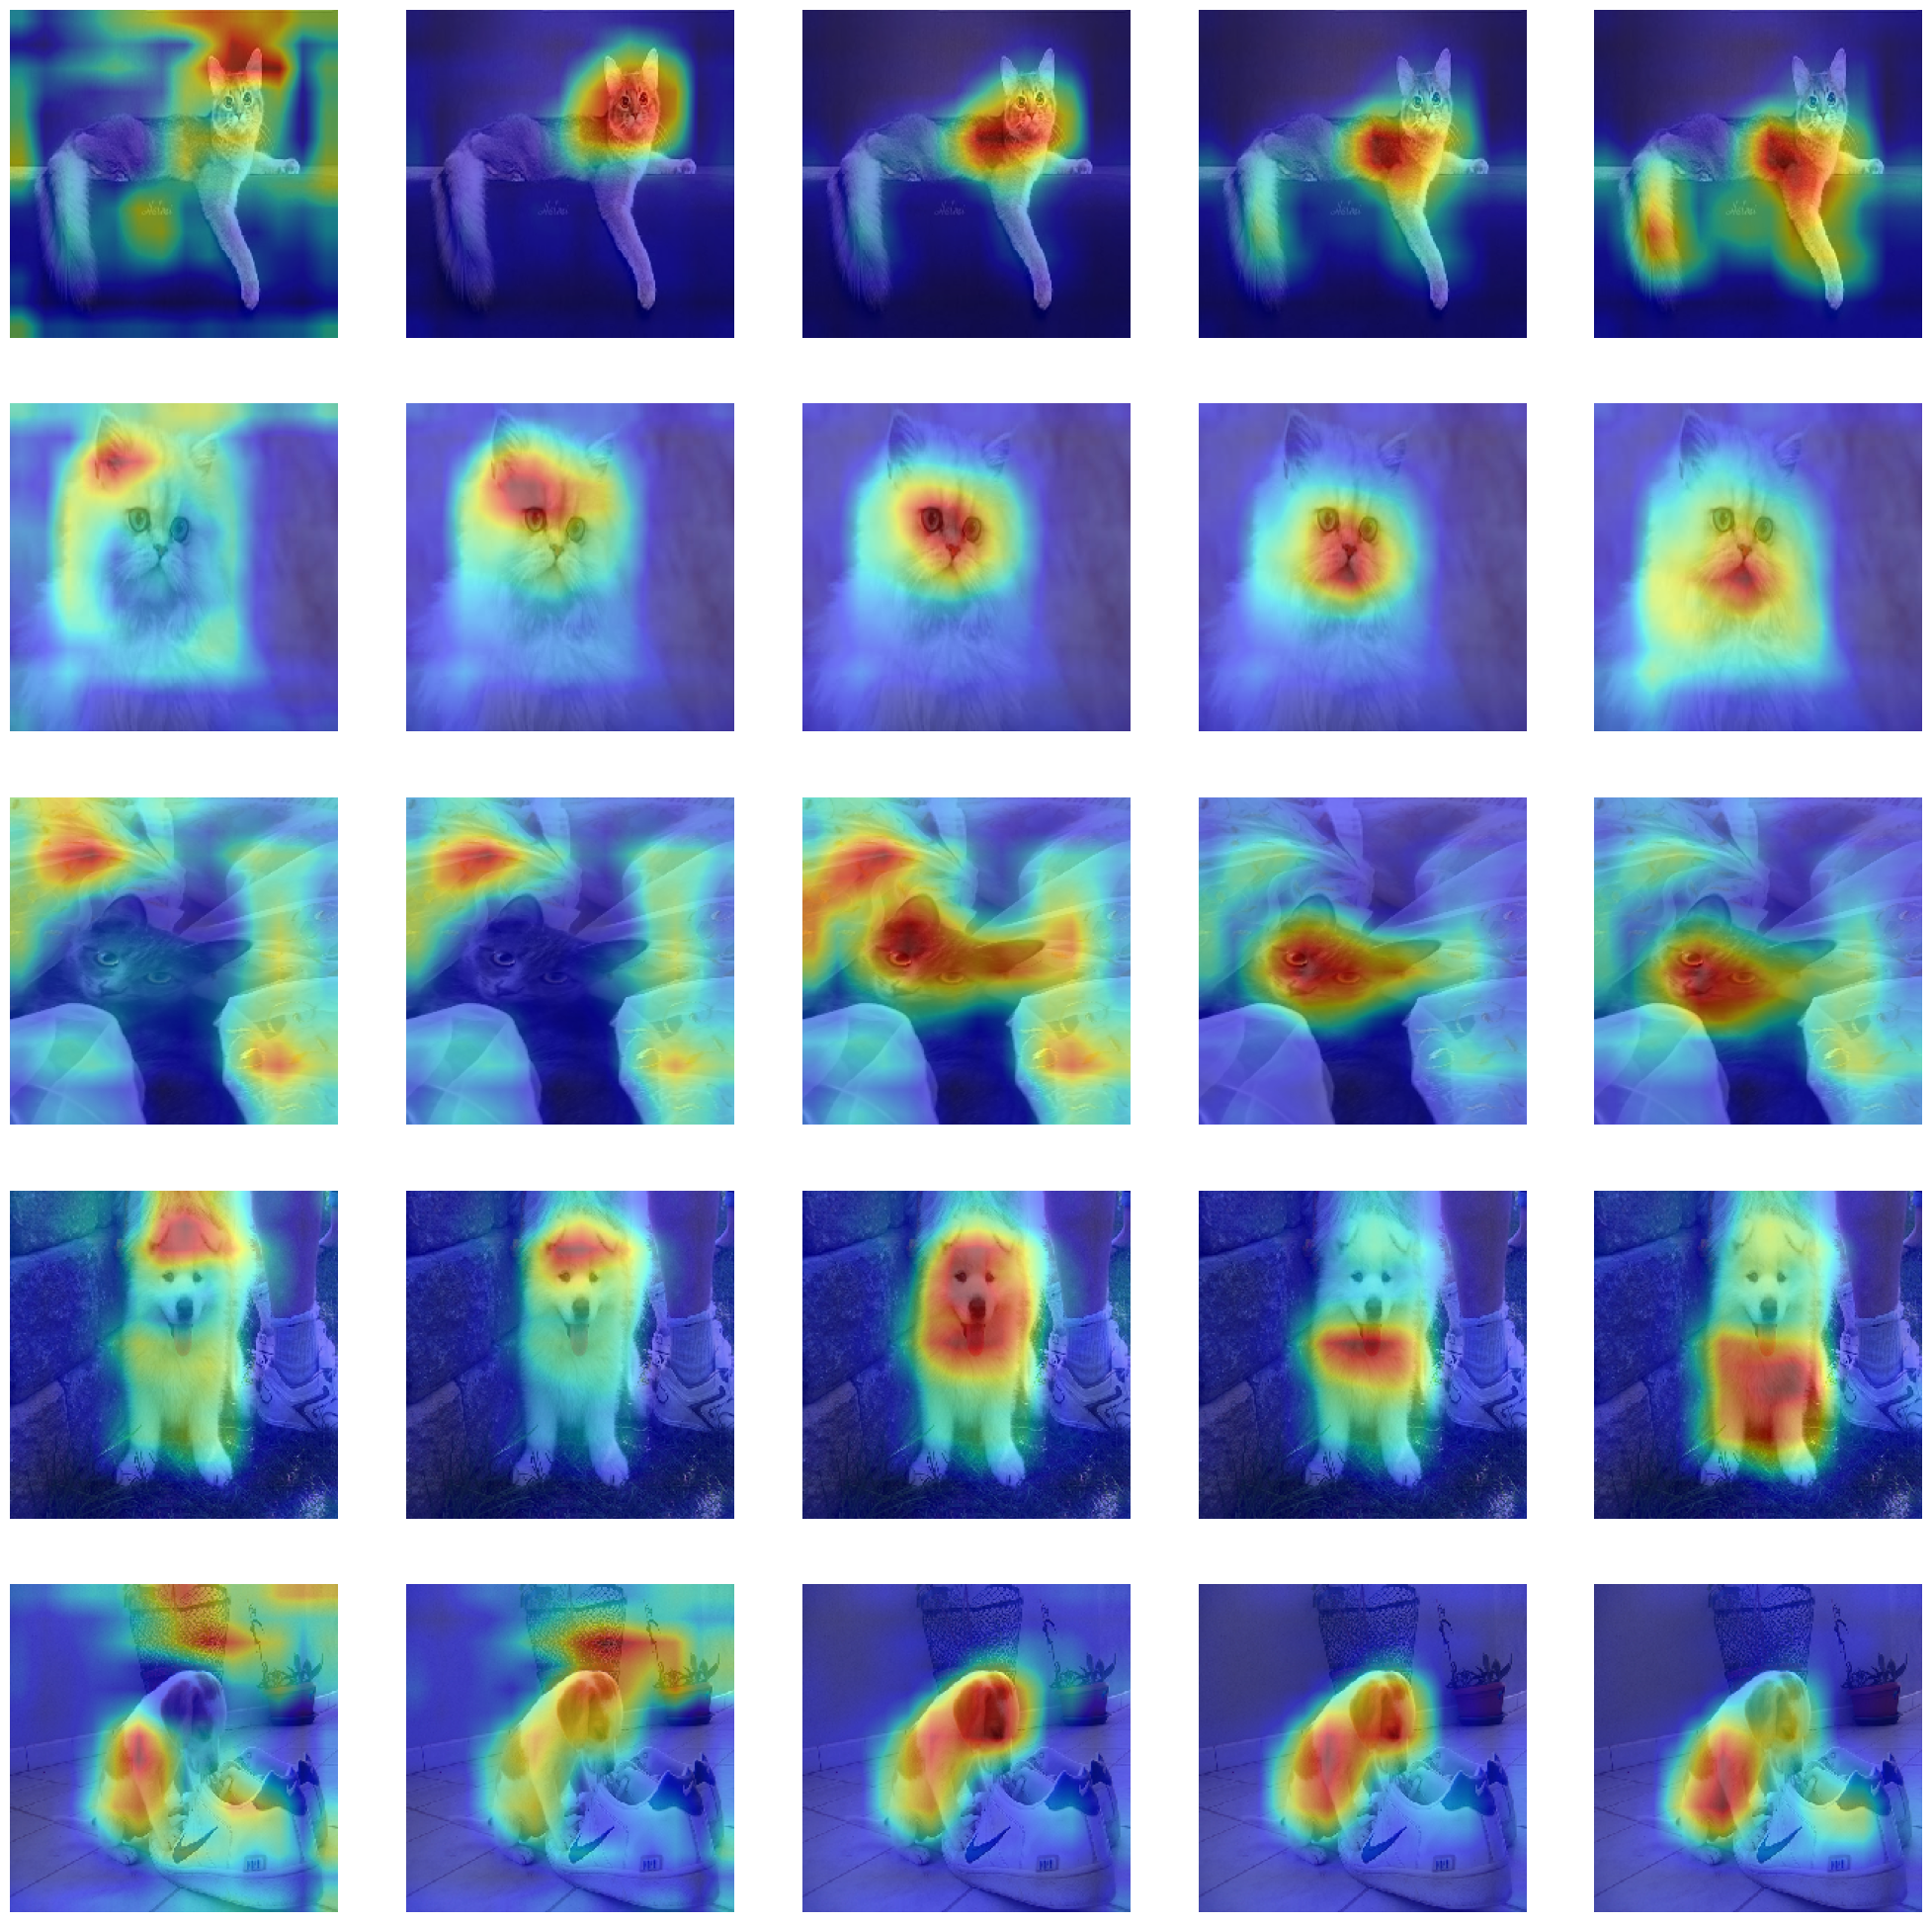

In [54]:
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
import tensorflow as tf

def grad_cam(model, image, category_index, layer_name):
    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, category_index]
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)
    heatmap = cv2.resize(heatmap, (224, 224))
    return heatmap

def process_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

image_paths = ['C:/Users/imedz/OneDrive/Desktop/AI/Labs2/images/Abyssinian_173.jpg',
               'C:/Users/imedz/OneDrive/Desktop/AI/Labs2/images/Persian_257.jpg',
               'C:/Users/imedz/OneDrive/Desktop/AI/Labs2/images/Russian_253.jpg',
               'C:/Users/imedz/OneDrive/Desktop/AI/Labs2/images/samoyed_85.jpg',
               'C:/Users/imedz/OneDrive/Desktop/AI/Labs2/images/beagle_160.jpg'
               ]
layer_name = 'block5_conv3'
model_vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

fig, axs = plt.subplots(5, 5, figsize=(25, 25))

for i, img_path in enumerate(image_paths):
    img = process_image(img_path)
    preds = model_vgg16.predict(img)
    predicted_class = np.argmax(preds[0])

    for j in range(5):  #Генерация CAM для первых 5 классов
        cam = grad_cam(model_vgg16, img, j, layer_name)
        axs[i, j].imshow(load_img(img_path, target_size=(224, 224)))
        axs[i, j].imshow(cam, cmap='jet', alpha=0.5)  #Наложение CAM на изображение
        axs[i, j].axis('off')

plt.show()